# 1. Import and Setup

In [71]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from scipy import stats
from scipy.stats import trim_mean
from sklearn.covariance import MinCovDet
from statsmodels.robust.scale import mad

%matplotlib inline

pd.options.display.max_rows = None
pd.options.display.max_columns = None

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

cmap1 = "Blues"

In [72]:
# import data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combine = [train_df, test_df]

# 2. Exploratory Data Analysis

## 2.1. Data Structure

In [73]:
# df shape
train_df.shape
test_df.shape

(891, 12)

(418, 11)

In [74]:
# sample rows
train_df.sample(8)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
164,165,0,3,"Panula, Master. Eino Viljami",male,1.00,4,1,3101295,39.6875,NaN,S
528,529,0,3,"Salonen, Mr. Johan Werner",male,39.00,0,0,3101296,7.9250,NaN,S
196,197,0,3,"Mernagh, Mr. Robert",male,NaN,0,0,368703,7.7500,NaN,Q
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
480,481,0,3,"Goodwin, Master. Harold Victor",male,9.00,5,2,CA 2144,46.9000,NaN,S
706,707,1,2,"Kelly, Mrs. Florence ""Fannie""",female,45.00,0,0,223596,13.5000,NaN,S
844,845,0,3,"Culumovic, Mr. Jeso",male,17.00,0,0,315090,8.6625,NaN,S
258,259,1,1,"Ward, Miss. Anna",female,35.00,0,0,PC 17755,512.3292,NaN,C


In [75]:
# columns, NULLs, and dtypes
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Numerical Features
- Age, SibSp, ParCh, Fare

In [76]:
# describe numerical features
num_cols = ['Mean', 'TrMean', 'Median', 'StDev', 'MADev']
num_feats = ['Age', 'SibSp', 'Parch', 'Fare']
mean = []
trimmed_mean = []
median = []
stdev = []
madev = []

# calculate values
for feature in num_feats:
    mean.append(train_df[feature].dropna().mean())
    trimmed_mean.append(trim_mean(train_df[feature].dropna(), 0.1))
    median.append(train_df[feature].dropna().median())
    stdev.append(train_df[feature].dropna().std())
    madev.append(mad(train_df[feature].dropna()))

# create and view table
num_feats_df = pd.DataFrame(list(zip(mean, trimmed_mean, median, stdev, madev)),
                            index = num_feats,
                            columns = num_cols)
num_feats_df.T.round(3)

,Age,SibSp,Parch,Fare
Mean,29.699,0.523,0.382,32.204
TrMean,29.269,0.272,0.182,21.379
Median,28.000,0.000,0.000,14.454
StDev,14.526,1.103,0.806,49.693
MADev,13.343,0.000,0.000,10.236


Text(0.5, 1.0, 'Age Distribution')

Text(0, 0.5, '')

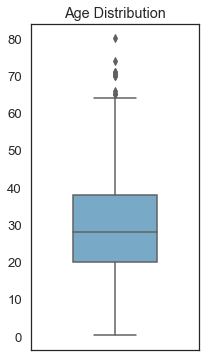

In [77]:
# AGE distribution - boxplot
sns.set(font_scale=1.2)
sns.set_style('white')
fig, ax = plt.subplots(figsize=(3, 6))
ax = sns.boxplot(train_df['Age'], width=0.5, orient='v', palette=cmap1)
ax.set_title('Age Distribution')
ax.set_ylabel('')

Text(0.5, 1.0, 'Sibling/Spouse Distribution')

Text(0.5, 0, '')

Text(0.5, 1.0, 'Parent/Children Distribution')

Text(0.5, 0, '')

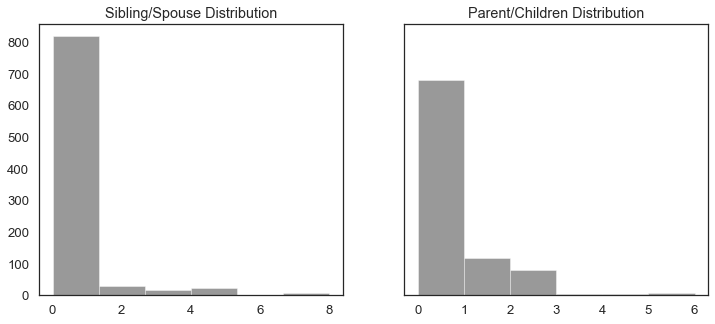

In [78]:
# SIBSP and PARCH distribution - histogram
sns.set(font_scale=1.2)
sns.set_style('white')
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))
sns.distplot(train_df['SibSp'], bins=6, kde=False, color='black', ax=ax1)
ax1.set_title('Sibling/Spouse Distribution')
ax1.set_xlabel('')
sns.distplot(train_df['Parch'], bins=6, kde=False, color='black', ax=ax2)
ax2.set_title('Parent/Children Distribution')
ax2.set_xlabel('')

# NOTE: Mostly zeroes

Text(0.5, 1.0, 'Fare Distribution')

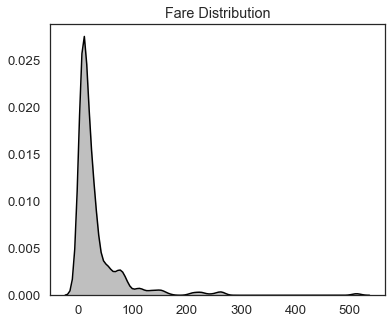

In [79]:
# FARE distribution - kernel density estimate
sns.set(font_scale=1.2)
sns.set_style('white')
fig, ax = plt.subplots(figsize=(6, 5))
sns.kdeplot(train_df['Fare'], shade=True, color='black', label='', bw=8)
ax.set_title('Fare Distribution')

# NOTE: right-skewed, needs to be transformed

### Categorical Features
- Pclass, Sex, Embarked

In [80]:
# describe categorical features
cat_feats = ['Pclass', 'Sex', 'Embarked']
for feature in cat_feats:
    train_df[feature].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

male      577
female    314
Name: Sex, dtype: int64

S    644
C    168
Q     77
Name: Embarked, dtype: int64

([<matplotlib.patches.Wedge at 0x2639c810f88>,
 [Text(-0.8280948334907877, 0.8684808269304882, ''),
  Text(-0.9896099621739102, -0.6787283129250999, ''),
  Text(1.1845905819442033, -0.19169025319273209, '')],
 [Text(-0.48305531953629277, 0.5066138157094515, '24%'),
  Text(-0.5772724779347809, -0.3959248492063082, '21%'),
  Text(0.6910111728007853, -0.11181931436242705, '55%')])

Text(0.5, 1.0, 'Class Distribution')

([<matplotlib.patches.Wedge at 0x2639c841a08>,
 [Text(-0.913931440427621, -0.7776434415578223, ''),
  Text(1.0893052658702065, 0.5034024610065377, ''),
  Text(0.3225130788540454, 1.155848309237888, '')],
 [Text(-0.5331266735827789, -0.45362534090872964, '72%'),
  Text(0.6354280717576204, 0.293651435587147, '19%'),
  Text(0.18813262933152647, 0.6742448470554346, '9%')])

Text(0.5, 1.0, 'Embarkment Distribution')

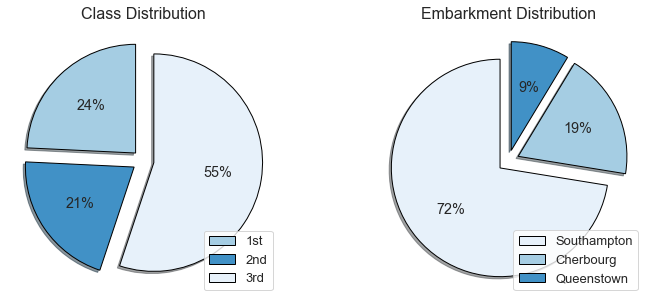

In [81]:
# PCLASS distribution - pie chart
labels_1 = '1st', '2nd', '3rd'
labels_2 = 'Southampton', 'Cherbourg', 'Queenstown'
cmap = plt.get_cmap("Blues")
colors_1 = cmap([90, 160, 20])
colors_2 = cmap([20, 90, 160])

fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
ax[0].pie([216, 184, 491], startangle=90, colors=colors_1, wedgeprops={'edgecolor':'black'}, 
        autopct='%1.f%%', shadow=True, explode=(0.1, 0.1, 0.1))
ax[0].set_title('Class Distribution', fontsize=16)
ax[0].legend(labels=labels_1, fontsize=13, loc=4)
ax[1].pie([644, 168, 77], startangle=90, colors=colors_2, wedgeprops={'edgecolor':'black'},
        autopct='%1.f%%', shadow=True, explode=(0.1, 0.1, 0.1))
ax[1].set_title('Embarkment Distribution', fontsize=16)
ax[1].legend(labels=labels_2, fontsize=13, loc=4)

## 2.2. Clean Your Data

- Address NULLs
- Split 'Cabin' into Deck, Rm_Num
- Split 'Name' into Title, Last
- Address Party Info
- Streamline Dataset

### Address NULLs

In [82]:
# create tables of % NULLs
for dataset in combine:
    pd.DataFrame({'Percent_NULL': (dataset.isnull().sum()/len(dataset)*100).sort_values(ascending=False)}).head(4)

,Percent_NULL
Cabin,77.104377
Age,19.865320
Embarked,0.224467
Fare,0.000000


,Percent_NULL
Cabin,78.229665
Age,20.574163
Fare,0.239234
Embarked,0.000000


The majority of cabin assignments are unknown but, if possible, I'd like to salvage this feature. It seems likely to influence survival. For now, I will assign a placeholder ('Z') for NULL values.

In [83]:
# fill NULLs with 'Z'
for dataset in combine:
    dataset['Cabin'].fillna('Z', inplace=True)

Other features could give us clues about passenger age. I will assign a placeholder (0) for NULL values until I can address it properly.

In [84]:
# fill NULLs with 0
for dataset in combine:
    dataset['Age'].fillna(0, inplace=True)

Embarkment location and fare are almost complete, so I will fill NULL values with the mode and mean, respectively.

In [88]:
# fill NULLs with mode/mean
for dataset in combine:
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)
    dataset['Fare'].fillna(dataset['Fare'].mean(), inplace=True)

In [89]:
# QA check
for dataset in combine:
    pd.DataFrame({'Percent_NULL': (dataset.isnull().sum()/len(dataset)*100).sort_values(ascending=False)}).head(4)

,Percent_NULL
Embarked,0.0
Cabin,0.0
Fare,0.0
Ticket,0.0


,Percent_NULL
Embarked,0.0
Cabin,0.0
Fare,0.0
Ticket,0.0


### Split Cabin Info

Cabin data (ex. A35) contain three different pieces of information: deck (A), cabin number (35), and cabin count (35, 40, 41 = 3 cabins). As such, I want to split 'Cabin' into 'Deck', 'CabinNum', and 'CabinCnt'.

In [90]:
for dataset in combine:
    dataset['Deck'] = dataset['Cabin'].apply(lambda x: re.findall(r"\D", x)[0])
    dataset['CabinNum'] = dataset['Cabin'].apply(lambda x: re.findall(r"\d{1,500}", x))
    dataset['CabinCnt'] = dataset['CabinNum'].apply(lambda x: len(x) if len(x)>0 else 'U')
    dataset['CabinNum'] = dataset['CabinNum'].apply(lambda x: x[0] if len(x)>0 else 'U')

### Split Name Info

I want to pull and parse 'Name' and keep the pieces I think are informative.

In [338]:
data['Last'] = data['Name'].apply(lambda x: x.split(',', 2)[0])
data['Name'] = data['Name'].apply(lambda x: x.split(',', 2)[1])
data['Title'] = data['Name'].apply(lambda x: x.split('.', 2)[0])

In [339]:
# clean up title
data['Title'].nunique()
titles = data['Title'].value_counts().reset_index(name='count').query('count>10')['index'].tolist()
data['Title'] = data['Title'].apply(lambda x: x if x in titles else 'Other')
print('Titles with >10 Records: {}'.format(titles))

18

Titles with >10 Records: [' Mr', ' Miss', ' Mrs', ' Master']


### Party Info
Tickets, ParCh, and SibSp might contain information about party size. Party size may impact survival. Traveling alone may also impact survival. I want to create 'PartySize' and 'IsAlone' for this information.

In [340]:
# Identify passengers sharing tickets
data['SharedTicket'] = data['Ticket'].apply(lambda x: 1 if x in data['Ticket'].value_counts().reset_index(name='count')\
                              .query('count>1')['index'].tolist() else 0)

In [341]:
# Calculate party size
data['PartySize'] = data['Parch']+data['SibSp']+1

In [345]:
# Create 'IsAlone' based on 'SharedTicket' and 'PartySize'
data['IsAlone'] = 0
data.loc[(data['SharedTicket'] == 0) & (data['PartySize'] == 1), 'IsAlone'] = 1

### Streamline Dataset

In [347]:
# check dataset
data.sample(8)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,CabinNum,CabinCnt,Last,Title,SharedTicket,PartySize,IsAlone
1104,1105,2,Mrs. Benjamin (Ellen Truelove Arman),female,60,1,0,24065,26.0000,U,S,U,U,U,Howard,Mrs,1,2,0
689,690,1,Miss. Georgette Alexandra,female,15,0,1,24160,211.3375,B5,S,B,5,1,Madill,Miss,1,2,0
745,746,1,Capt. Edward Gifford,male,70,1,1,WE/P 5735,71.0000,B22,S,B,22,1,Crosby,Other,1,3,0
155,156,1,Mr. Charles Duane,male,51,0,1,PC 17597,61.3792,U,C,U,U,U,Williams,Mr,1,2,0
1065,1066,3,Mr. Carl Oscar Vilhelm Gustafsson,male,40,1,5,347077,31.3875,U,S,U,U,U,Asplund,Mr,1,7,0
136,137,1,Miss. Helen Monypeny,female,19,0,2,11752,26.2833,D47,S,D,47,1,Newsom,Miss,0,3,0
358,359,3,Miss. Mary,female,U,0,0,330931,7.8792,U,Q,U,U,U,McGovern,Miss,0,1,1
1173,1174,3,Miss. Honora,female,U,0,0,364859,7.7500,U,Q,U,U,U,Fleming,Miss,0,1,1


In [255]:
# drop uninformative columns
data = data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'CabinCnt', 'Last'])

In [256]:
# rename columns
data = data.rename(columns={'Sex':'Gender', 'Pclass':'Class', 'CabinNum':'Cabin', 'Parch':'ParCh'})

In [257]:
# re-order columns
order = ['Title', 'Gender', 'Age', 'SibSp', 'ParCh', 'IsAlone', 'Class', 'Fare', 'Deck', 'Cabin', 'Embarked']
data = data[order]

In [258]:
# make columns numeric
data['Gender'] = data['Gender'].map({'male':1, 'female':0})
data['Deck'] = data['Deck'].map({'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8, 'U':8})
data['Embarked'] = data['Embarked'].map({'C':1, 'Q':2, 'S':3})
data['Title'] = data['Title'].map({' Mr':1, ' Mrs':2, ' Master':3, ' Miss':4, 'Other':5})

In [259]:
# check dataset
data.head(8)

,Title,Gender,Age,SibSp,ParCh,Party,Class,Fare,Deck,Cabin,Embarked
0,1,1,22,1,0,1,3,7.2500,8,U,3
1,2,0,38,1,0,1,1,71.2833,3,85,1
2,4,0,26,0,0,0,3,7.9250,8,U,3
3,2,0,35,1,0,1,1,53.1000,3,123,3
4,1,1,35,0,0,0,3,8.0500,8,U,3
5,1,1,U,0,0,0,3,8.4583,8,U,2
6,1,1,54,0,0,1,1,51.8625,5,46,3
7,3,1,2,3,1,1,3,21.0750,8,U,3


## 2.3. Explore Relationships
### Numerical Features
- Age, SibSp, ParCh, Fare

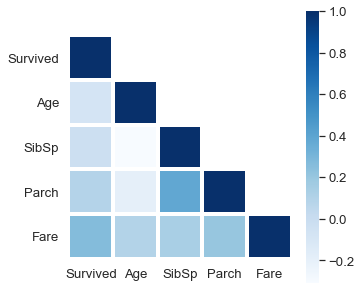

In [42]:
# correlation matrix heatmap
params = ['Survived', 'Age', 'SibSp', 'Parch', 'Fare']
coefs = np.corrcoef(train_df[params].dropna().T)
mask = np.zeros_like(coefs)
mask[np.triu_indices_from(mask, 1)] = True
with sns.axes_style('white'):
    f, ax = plt.subplots(figsize=(5, 5))
    sns.set(font_scale=1.2)
    sns.heatmap(coefs, cmap='Blues', cbar=True, annot=False, square=True, fmt='.1f', annot_kws={'size':12},
               yticklabels=params, xticklabels=params, linewidths=3, linecolor='white', mask=mask)

### Categorical Features
- Pclass, Sex, Embarked

Text(0.5, 1.0, 'Survival Rate by Sex and Economic Class')

Text(0, 0.5, 'Survival Rate')

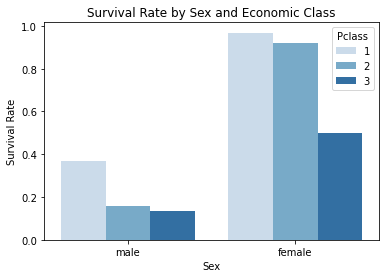

In [322]:
# middle and upper class females took priority
ax = sns.barplot(x='Sex', y='Survived', hue='Pclass', data=train_target, ci=None, palette=cmap1)
ax.set_title('Survival Rate by Sex and Economic Class')
ax.set_ylabel('Survival Rate')

#### x = age + class | y = survival

In [323]:
# group passengers by age
train_target['AgeGrp'] = pd.cut(x=train_target['Age'], bins=[0, 17, 35, 60, 100], labels=['Child', 'YngAdult', 'OldAdult', 'Elderly'])

Text(0.5, 1.0, 'Survival Rate by Age and Economic Class')

Text(0.5, 0, 'Age Group')

Text(0, 0.5, 'Survival Rate')

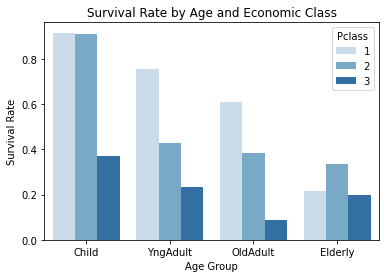

In [324]:
# younger passengers took priority
ax = sns.barplot(x='AgeGrp', y='Survived', hue='Pclass', data=train_target, ci=None, palette=cmap1)
ax.set_title('Survival Rate by Age and Economic Class')
ax.set_xlabel('Age Group')
ax.set_ylabel('Survival Rate')

Text(0.5, 1.0, 'Survival Rate by Sex and Economic Class')

Text(0, 0.5, 'Survival Rate')

Text(0.5, 1.0, 'Survival Rate by Age and Economic Class')

Text(0.5, 0, 'Age Group')

Text(0, 0.5, '')

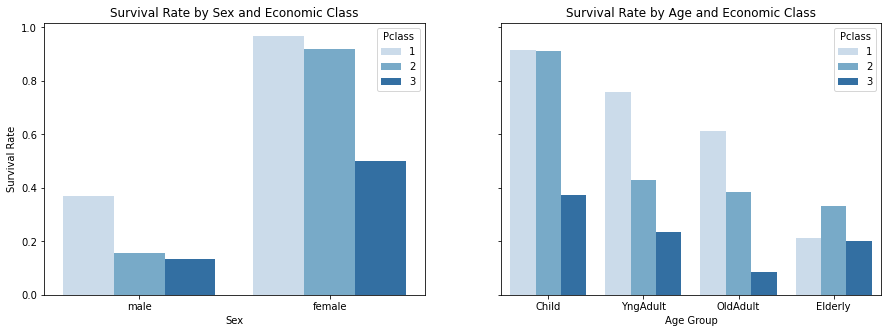

In [325]:
# joint figure
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15, 5))
sns.barplot(x='Sex', y='Survived', hue='Pclass', data=train_target, ci=None, palette=cmap1, ax=ax1)
ax1.set_title('Survival Rate by Sex and Economic Class')
ax1.set_ylabel('Survival Rate')
sns.barplot(x='AgeGrp', y='Survived', hue='Pclass', data=train_target, ci=None, palette=cmap1, ax=ax2)
ax2.set_title('Survival Rate by Age and Economic Class')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('')

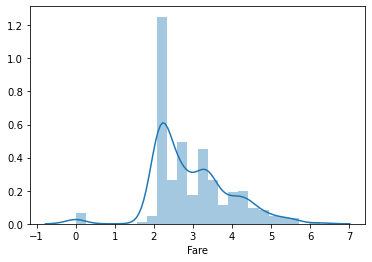

In [326]:
# fix fare skew
fare_log = np.log1p(train_target['Fare'])
sns.distplot(fare_log)

#### x = fare | y = survival

Text(0.5, 1.0, 'Passenger Fare by Fate')

Text(0, 0.5, 'Fare (log(x+1))')

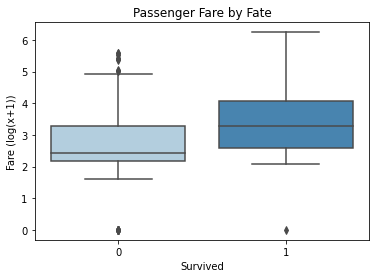

In [327]:
# minimal influence of fare on survival
ax = sns.boxplot(x=train_target['Survived'], y=fare_log, palette=cmap1)
ax.set_title('Passenger Fare by Fate')
ax.set_ylabel('Fare (log(x+1))')

In [328]:
# check NULLS for cabin assignments
print('Cabin, Percent NULL: {}'.format(train_target['Cabin'].isnull().sum()/len(train_target)*100))

Cabin, Percent NULL: 77.10437710437711


#### x = embarkment + class | y = survival

In [329]:
embark_df = pd.pivot_table(train_target, values=['Survived', 'PassengerId'], index=['Embarked', 'Pclass'], 
                           aggfunc={'Survived': np.mean, 'PassengerId': pd.Series.nunique}, margins=True, margins_name='Total')
embark_df.reset_index(inplace=True)
embark_df.rename(columns={'Embarked':'Location', 'Pclass':'Class', 'PassengerId':'Count', 
                          'Survived':'% Survived'})

,Location,Class,Count,% Survived
0,C,1,85,0.694118
1,C,2,17,0.529412
2,C,3,66,0.378788
3,Q,1,2,0.500000
4,Q,2,3,0.666667
5,Q,3,72,0.375000
6,S,1,127,0.582677
7,S,2,164,0.463415
8,S,3,353,0.189802
9,Total,,889,0.382452


In [330]:
pd.pivot_table(train_target, values='Survived', index='Pclass', aggfunc=np.mean)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [331]:
# some tickets were shared
train_target['Ticket'].nunique()

681

## 3. Visualize Your Data

In [101]:
# re-create train_target dataset
train_target = pd.concat((data[:len_train], target), axis=1)

### 3.1. Influence of Title on Survival Rate

Text(0.5, 0, 'Title')

Text(0, 0.5, 'Survival Rate')

Text(0.5, 1.0, 'Survival Rate by Title and Economic Class')

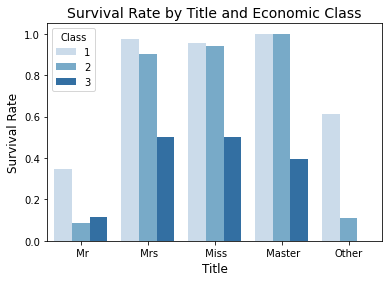

In [40]:
ax = sns.barplot(x='Title', y='Survived', hue='Class', data=train_target, ci=None, palette=cmap1)
ax.set_xlabel('Title', fontsize=12)
ax.set_ylabel('Survival Rate', fontsize=12)
ax.set_title('Survival Rate by Title and Economic Class', fontsize=14)

### 3.2. Influence of Cabin Location on Survival Rate

In [41]:
# create cabin number subset
train_cabin = train_target.loc[train_target['Cabin'] != 'U'].copy()
train_cabin['Cabin'] = train_cabin['Cabin'].astype(int)

Text(0.5, 1.0, 'Mean Cabin Number by Survived')

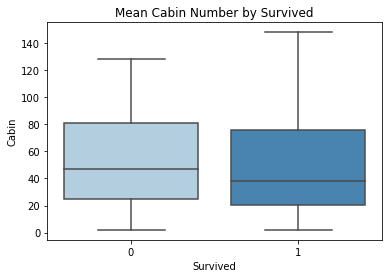

In [42]:
ax = sns.boxplot(x='Survived', y='Cabin', data=train_cabin, palette=cmap1)
ax.set_title('Mean Cabin Number by Survived')

In [43]:
# create deck subset
train_deck = train_target.loc[train_target['Deck'] != 8].copy()

Text(0.5, 1.0, 'Survival Rate by Deck')

[(0.0, 1.0)]

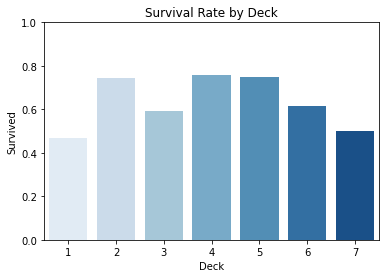

In [44]:
ax = sns.barplot(x='Deck', y='Survived', data=train_deck, ci=None, palette=cmap1)
ax.set_title('Survival Rate by Deck')
ax.set(ylim=(0, 1))

### 3.3. Relationship Between Deck and Class

In [45]:
# deck distribution by class
deck_dist = pd.pivot_table(train_target, values=['ID'], index=['Deck'], columns=['Class'], dropna=False, fill_value=0,
                           aggfunc={'ID':pd.Series.nunique}, margins=True, margins_name='Total')
deck_dist.rename(columns={'ID':''})

Class    1    2    3 Total
Deck                      
1       15    0    0    15
2       47    0    0    47
3       59    0    0    59
4       29    4    0    33
5       25    4    3    32
6        0    8    5    13
7        0    0    4     4
8       41  168  479   688
Total  216  184  491   891

### 3.4. Influence of Relations on Survival Rate

[(0.0, 1.0)]

Text(0.5, 1.0, 'Influence of Party on Survival Rate')

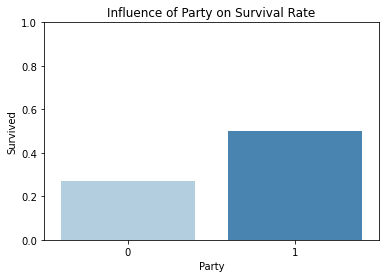

In [46]:
ax = sns.barplot(x='Party', y='Survived', data=train_target, ci=None, palette=cmap1)
ax.set(ylim=(0, 1))
ax.set_title('Influence of Party on Survival Rate')

[(0.0, 1.0)]

Text(0.5, 1.0, 'Survival by Number of Sib/Sp On-board')

Text(0.5, 1.0, 'Survival by Number of Par/Ch On-board')

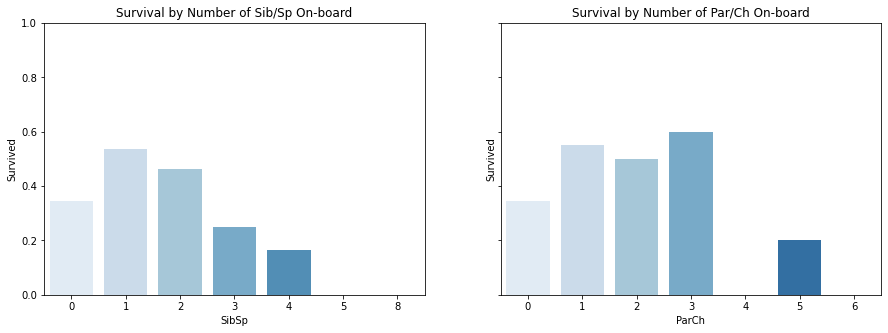

In [47]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15, 5))
sns.barplot(x='SibSp', y='Survived', data=train_target, ci=None, palette=cmap1, ax=ax1)
sns.barplot(x='ParCh', y='Survived', data=train_target, ci=None, palette=cmap1, ax=ax2)
ax1.set(ylim=(0, 1))
ax1.set_title('Survival by Number of Sib/Sp On-board')
ax2.set_title('Survival by Number of Par/Ch On-board')

In [102]:
# check datasets
train_target.sample(8)
data.sample(8)
train_target.info()
data.info()

,ID,Title,Last,Gender,Age,SibSp,ParCh,Party,Class,Deck,Cabin,Embarked,Survived
524,525,Mr,Kassem,1,U,0,0,0,3,8,U,C,0
605,606,Mr,Lindell,1,36,1,0,1,3,8,U,S,0
666,667,Mr,Butler,1,25,0,0,0,2,8,U,S,0
720,721,Miss,Harper,0,6,0,1,1,2,8,U,S,1
511,512,Mr,Webber,1,U,0,0,0,3,8,U,S,0
107,108,Mr,Moss,1,U,0,0,0,3,8,U,S,1
691,692,Miss,Karun,0,4,0,1,1,3,8,U,C,1
103,104,Mr,Johansson,1,33,0,0,0,3,8,U,S,0


,ID,Title,Last,Gender,Age,SibSp,ParCh,Party,Class,Deck,Cabin,Embarked
39,40,Miss,Nicola-Yarred,0,14,1,0,1,3,8,U,C
362,363,Mrs,Barbara,0,45,0,1,1,3,8,U,C
939,940,Mrs,Bucknell,0,60,0,0,1,1,4,15,C
699,700,Mr,Humblen,1,42,0,0,0,3,6,63,S
936,937,Mr,Peltomaki,1,25,0,0,0,3,8,U,S
355,356,Mr,Vanden Steen,1,28,0,0,0,3,8,U,S
1260,1261,Mr,Pallas y Castello,1,29,0,0,0,2,8,U,C
344,345,Mr,Fox,1,36,0,0,0,2,8,U,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        891 non-null    int64 
 1   Title     891 non-null    object
 2   Last      891 non-null    object
 3   Gender    891 non-null    int64 
 4   Age       891 non-null    object
 5   SibSp     891 non-null    int64 
 6   ParCh     891 non-null    int64 
 7   Party     891 non-null    int64 
 8   Class     891 non-null    int64 
 9   Deck      891 non-null    int64 
 10  Cabin     891 non-null    object
 11  Embarked  891 non-null    object
 12  Survived  891 non-null    int64 
dtypes: int64(8), object(5)
memory usage: 90.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ID        1309 non-null   int64 
 1   Title     1309 non-null   object
 2   Last      

In [54]:
train_target = pd.get_dummies(train_target)
data = pd.get_dummies(data)
train_target.shape
data.shape

(891, 865)

(1309, 1094)

## 4. Build Models

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [56]:
y_train = train_target['Survived']
x_train = train_target.drop('Survived', axis=1)
test = data[-len_test:]

In [57]:
y_train.shape
x_train.shape
test.shape

(891,)

(891, 864)

(418, 1094)

In [52]:
rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rf_clf.fit(x_train, y_train)

ValueError: could not convert string to float: ' Mr'